In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload

In [2]:
import sys
sys.path.append('../')

In [3]:
%%writefile ../src/full_agent.py

"""This code contains the complete Inbound MultiAgent System"""

import os
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver

from src.supervisor_schema import AgentInputState
from src.supervisor_agent import DelegateNextAgent, clarify_with_user, supervisor_agent, supervisor_tools
from src.logistics_agent import LogisticsAgent , LogisticsState
from src.forwarder_agent import ForwarderAgent

# Build the scoping workflow
full_agent_builder = StateGraph(LogisticsState, input_schema=AgentInputState)

# Add workflow nodes
full_agent_builder.add_node("supervisor_agent"  , supervisor_agent)
full_agent_builder.add_node("supervisor_tools"  , supervisor_tools)
full_agent_builder.add_node("clarify_with_user" , clarify_with_user)
full_agent_builder.add_node("LogisticsAgent"    , LogisticsAgent)
full_agent_builder.add_node("ForwarderAgent"    , ForwarderAgent)

# Add workflow edges
full_agent_builder.add_edge(START, "supervisor_agent")
full_agent_builder.add_conditional_edges(
    "supervisor_agent",
     DelegateNextAgent,
    {
        "supervisor_tools"  : "supervisor_tools" , 
        "clarify_with_user" : "clarify_with_user", 
        "logistics_agent"   : "LogisticsAgent"   ,
        "forwarder_agent"   : "ForwarderAgent"
    },
)
full_agent_builder.add_edge("supervisor_tools", "supervisor_agent")
full_agent_builder.add_edge("clarify_with_user", END)

# Compile the workflow
checkpointer = InMemorySaver()
full_agent = full_agent_builder.compile(checkpointer = checkpointer)

Overwriting ../src/full_agent.py


c:\Users\kamalmo\Desktop\AI\InboundLogisticSystem\MultiAgentInboundLogistic\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


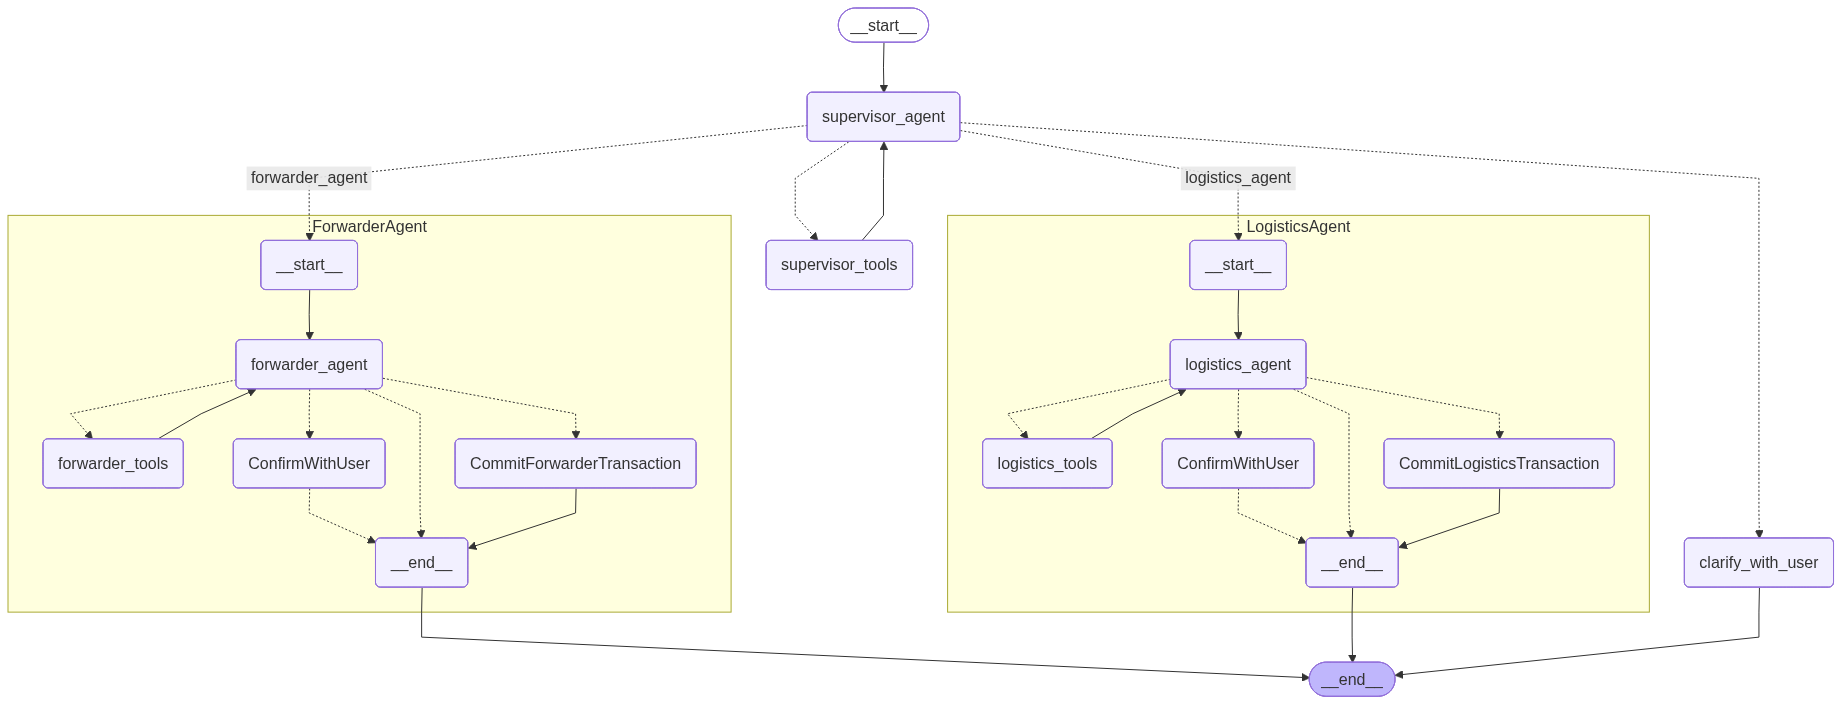

In [4]:
from IPython.display import Image, display
from src.full_agent import full_agent

# Show the agent
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

In [4]:
from src.utils import format_message
from langchain_core.messages import HumanMessage
from src.full_agent import full_agent

thread = {"configurable":{"thread_id":"1"}}
result = await full_agent.ainvoke({"messages":[HumanMessage(content="I want to enter the AWB/BL 12345 and AWB Date")]} , config=thread)
format_message(result["messages"])

c:\Users\kamalmo\Desktop\AI\InboundLogisticSystem\MultiAgentInboundLogistic\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the AWB/BL 12345 and AWB Date                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Please provide the AWB/BL Date (in YYYY-MM-DD format) so we can proceed with your request.                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
result = await full_agent.ainvoke({"messages":[HumanMessage(content="Skip")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the AWB/BL 12345 and AWB Date                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Please provide the AWB/BL Date (in YYYY-MM-DD format) so we can proceed with your request.                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ You have provided the AWB/BL number (12345) but chose to skip entering the AWB/BL Date, which is a required     │
│ field. Would you like to proceed without the AWB/BL Date, or do you want to provide it now?                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [6]:
result = await full_agent.ainvoke({"messages":[HumanMessage(content="Please continue")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the AWB/BL 12345 and AWB Date                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Please provide the AWB/BL Date (in YYYY-MM-DD format) so we can proceed with your request.                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ You have provided the AWB/BL number (12345) but chose to skip entering the AWB/BL Date, which is a required     │
│ field. Would you like to proceed without the AWB/BL Date, or do you want to provide it now?                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Please continue                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ You have provided the AWB/BL number (12345) but chose to skip the required AWB/BL Date. Would you like to       │
│ proceed without the AWB/BL Date, or do you want to provide it now? Please confirm your preference so we can     │
│ assign the task appropriately.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [7]:
result = await full_agent.ainvoke({"messages":[HumanMessage(content="The Shipment Mode is Air")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the AWB/BL 12345 and AWB Date                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Please provide the AWB/BL Date (in YYYY-MM-DD format) so we can proceed with your request.                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ You have provided the AWB/BL number (12345) but chose to skip entering the AWB/BL Date, which is a required     │
│ field. Would you like to proceed without the AWB/BL Date, or do you want to provide it now?                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Please continue                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ You have provided the AWB/BL number (12345) but chose to skip the required AWB/BL Date. Would you like to       │
│ proceed without the AWB/BL Date, or do you want to provide it now? Please confirm your preference so we can     │
│ assign the task appropriately.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The Shipment Mode is Air                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ You have provided the AWB/BL number (12345) and Shipment Mode (Air), but the required AWB/BL Date is missing.   │
│ Would you like to proceed without the AWB/BL Date, or do you want to provide it now? Please confirm your        │
│ preference.                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [8]:
result = await full_agent.ainvoke({"messages":[HumanMessage(content="AWB/BL Date is 2025-09-30")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the AWB/BL 12345 and AWB Date                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Please provide the AWB/BL Date (in YYYY-MM-DD format) so we can proceed with your request.                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ You have provided the AWB/BL number (12345) but chose to skip entering the AWB/BL Date, which is a required     │
│ field. Would you like to proceed without the AWB/BL Date, or do you want to provide it now?                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Please continue                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ You have provided the AWB/BL number (12345) but chose to skip the required AWB/BL Date. Would you like to       │
│ proceed without the AWB/BL Date, or do you want to provide it now? Please confirm your preference so we can     │
│ assign the task appropriately.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The Shipment Mode is Air                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ You have provided the AWB/BL number (12345) and Shipment Mode (Air), but the required AWB/BL Date is missing.   │
│ Would you like to proceed without the AWB/BL Date, or do you want to provide it now? Please confirm your        │
│ preference.                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ AWB/BL Date is 2025-09-30                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The following inbound logistics data has been provided: AWB/BL: 12345, AWB/BL Date: 2025-09-30, Shipment Mode:  │
│ Air. All required fields for logistics have been supplied. Assigning this task to the Logistics Agent for       │
│ further handling.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission, which could help make your record more complete:         │
│                                                                                                                 │
│ - Forwarder                                                                                                     │
│ - Product Temperature                                                                                           │
│ - Packing                                                                                                       │
│ - Shipping Temp                                                                                                 │
│ - Gel Pack Expiry Date                                                                                          │
│ - Handover to Clearance                                                                                         │
│ - Aggregation                                                                                                   │
│ - Notified FF Date                                                                                              │
│ - Green light - Date                                                                                            │
│ - Logistic Comment                                                                                              │
│ - Remark                                                                                                        │
│ - ASN Importation Date                                                                                          │
│                                                                                                                 │
│ You can provide any of these now, skip them and proceed, or add them later. Let me know how you’d like to       │
│ continue!                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [9]:
result = await full_agent.ainvoke({"messages":[HumanMessage(content="skip")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the AWB/BL 12345 and AWB Date                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Please provide the AWB/BL Date (in YYYY-MM-DD format) so we can proceed with your request.                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ You have provided the AWB/BL number (12345) but chose to skip entering the AWB/BL Date, which is a required     │
│ field. Would you like to proceed without the AWB/BL Date, or do you want to provide it now?                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Please continue                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ You have provided the AWB/BL number (12345) but chose to skip the required AWB/BL Date. Would you like to       │
│ proceed without the AWB/BL Date, or do you want to provide it now? Please confirm your preference so we can     │
│ assign the task appropriately.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The Shipment Mode is Air                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ You have provided the AWB/BL number (12345) and Shipment Mode (Air), but the required AWB/BL Date is missing.   │
│ Would you like to proceed without the AWB/BL Date, or do you want to provide it now? Please confirm your        │
│ preference.                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ AWB/BL Date is 2025-09-30                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The following inbound logistics data has been provided: AWB/BL: 12345, AWB/BL Date: 2025-09-30, Shipment Mode:  │
│ Air. All required fields for logistics have been supplied. Assigning this task to the Logistics Agent for       │
│ further handling.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission, which could help make your record more complete:         │
│                                                                                                                 │
│ - Forwarder                                                                                                     │
│ - Product Temperature                                                                                           │
│ - Packing                                                                                                       │
│ - Shipping Temp                                                                                                 │
│ - Gel Pack Expiry Date                                                                                          │
│ - Handover to Clearance                                                                                         │
│ - Aggregation                                                                                                   │
│ - Notified FF Date                                                                                              │
│ - Green light - Date                                                                                            │
│ - Logistic Comment                                                                                              │
│ - Remark                                                                                                        │
│ - ASN Importation Date                                                                                          │
│                                                                                                                 │
│ You can provide any of these now, skip them and proceed, or add them later. Let me know how you’d like to       │
│ continue!                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The following inbound logistics data has been provided and all required fields are present:                     │
│ - AWB/BL: 12345                                                                                                 │
│ - AWB/BL Date: 2025-09-30                                                                                       │
│ - Shipment Mode: Air                                                                                            │
│ The user has chosen to skip all optional fields. Assigning this task to the Logistics Agent for further         │
│ handling.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here is the final list of fields for your confirmation:                                                         │
│                                                                                                                 │
│ - AWB/BL: 12345                                                                                                 │
│ - AWB/BL Date: 2025-09-30                                                                                       │
│ - Shipment Mode: Air                                                                                            │
│                                                                                                                 │
│ The following optional fields are still missing:                                                                │
│ - Forwarder                                                                                                     │
│ - Product Temperature                                                                                           │
│ - Packing                                                                                                       │
│ - Shipping Temp                                                                                                 │
│ - Gel Pack Expiry Date                                                                                          │
│ - Handover to Clearance                                                                                         │
│ - Aggregation                                                                                                   │
│ - Notified FF Date                                                                                              │
│ - Green light - Date                                                                                            │
│ - Logistic Comment                                                                                              │
│ - Remark                                                                                                        │
│ - ASN Importation Date                                                                                          │
│                                                                                                                 │
│ No mandatory fields are missing.                                                                                │
│                                                                                                                 │
│ Please confirm if this information is correct and if you wish to proceed.                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [10]:
result = await full_agent.ainvoke({"messages":[HumanMessage(content="confirm")]} , config=thread)
format_message(result["messages"])

UnsupportedOperation: fileno

In [11]:
from src.utils import format_message
from langchain_core.messages import HumanMessage
from src.full_agent import full_agent

thread = {"configurable":{"thread_id":"2"}}
result = await full_agent.ainvoke({"messages":[HumanMessage(content="I want to enter the Shipment Readiness Date is 2025-09-30")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the Shipment Readiness Date is 2025-09-30                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided a Shipment Readiness Date of 2025-09-30. This field pertains to the responsibilities of   │
│ the Forwarder Agent. Assigning this task to the Forwarder Agent for further processing.                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Information**                                                                              │
│                                                                                                                 │
│ I cannot proceed with the Forwarder request until the following required field is provided:                     │
│                                                                                                                 │
│ - **Pick Up Date**                                                                                              │
│                                                                                                                 │
│ **How to provide the information:**                                                                             │
│ Please reply with the missing detail in a clear format, for example:                                            │
│ - Pick Up Date: 2024-07-15                                                                                      │
│                                                                                                                 │
│ If you need help or clarification about this field, let me know!                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [12]:
result = await full_agent.ainvoke({"messages":[HumanMessage(content="I want to enter the Shipment Readiness Date is 2025-09-30 and Pick up date is 2025-08-30")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the Shipment Readiness Date is 2025-09-30                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided a Shipment Readiness Date of 2025-09-30. This field pertains to the responsibilities of   │
│ the Forwarder Agent. Assigning this task to the Forwarder Agent for further processing.                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Information**                                                                              │
│                                                                                                                 │
│ I cannot proceed with the Forwarder request until the following required field is provided:                     │
│                                                                                                                 │
│ - **Pick Up Date**                                                                                              │
│                                                                                                                 │
│ **How to provide the information:**                                                                             │
│ Please reply with the missing detail in a clear format, for example:                                            │
│ - Pick Up Date: 2024-07-15                                                                                      │
│                                                                                                                 │
│ If you need help or clarification about this field, let me know!                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the Shipment Readiness Date is 2025-09-30 and nd Pick up date is 2025-08-30                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the following details: Shipment Readiness Date: 2025-09-30 and Pick Up Date: 2025-08-30.  │
│ Both fields pertain to the responsibilities of the Forwarder Agent. Assigning this task to the Forwarder Agent  │
│ for further processing.                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission, including:                                               │
│ - No. of Pallets                                                                                                │
│ - No. of Containers                                                                                             │
│ - Commodity Description                                                                                         │
│ - Country of Origin                                                                                             │
│ - Airport/Seaport Name                                                                                          │
│ - Shipping Line/Airline                                                                                         │
│ - Port of Destination                                                                                           │
│ - Actual ATA - FF                                                                                               │
│ - Gross Weight (KG)                                                                                             │
│ - CBM                                                                                                           │
│ - ETD                                                                                                           │
│ - Chargeable Weight (KG)                                                                                        │
│ - Freight Cost                                                                                                  │
│ - Total Value of Goods                                                                                          │
│ - Freight Invoice Number                                                                                        │
│ - ETA                                                                                                           │
│ - Freight Comment                                                                                               │
│                                                                                                                 │
│ You can provide any of these now to complete your record, skip them and proceed, or add them later. Please let  │
│ me know how you'd like to continue.                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [13]:
result = await full_agent.ainvoke({"messages":[HumanMessage(content="skip")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the Shipment Readiness Date is 2025-09-30                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided a Shipment Readiness Date of 2025-09-30. This field pertains to the responsibilities of   │
│ the Forwarder Agent. Assigning this task to the Forwarder Agent for further processing.                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Information**                                                                              │
│                                                                                                                 │
│ I cannot proceed with the Forwarder request until the following required field is provided:                     │
│                                                                                                                 │
│ - **Pick Up Date**                                                                                              │
│                                                                                                                 │
│ **How to provide the information:**                                                                             │
│ Please reply with the missing detail in a clear format, for example:                                            │
│ - Pick Up Date: 2024-07-15                                                                                      │
│                                                                                                                 │
│ If you need help or clarification about this field, let me know!                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the Shipment Readiness Date is 2025-09-30 and nd Pick up date is 2025-08-30                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the following details: Shipment Readiness Date: 2025-09-30 and Pick Up Date: 2025-08-30.  │
│ Both fields pertain to the responsibilities of the Forwarder Agent. Assigning this task to the Forwarder Agent  │
│ for further processing.                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission, including:                                               │
│ - No. of Pallets                                                                                                │
│ - No. of Containers                                                                                             │
│ - Commodity Description                                                                                         │
│ - Country of Origin                                                                                             │
│ - Airport/Seaport Name                                                                                          │
│ - Shipping Line/Airline                                                                                         │
│ - Port of Destination                                                                                           │
│ - Actual ATA - FF                                                                                               │
│ - Gross Weight (KG)                                                                                             │
│ - CBM                                                                                                           │
│ - ETD                                                                                                           │
│ - Chargeable Weight (KG)                                                                                        │
│ - Freight Cost                                                                                                  │
│ - Total Value of Goods                                                                                          │
│ - Freight Invoice Number                                                                                        │
│ - ETA                                                                                                           │
│ - Freight Comment                                                                                               │
│                                                                                                                 │
│ You can provide any of these now to complete your record, skip them and proceed, or add them later. Please let  │
│ me know how you'd like to continue.                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ skip                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the following details: Shipment Readiness Date: 2025-09-30 and Pick Up Date: 2025-08-30.  │
│ The user has chosen to skip all optional fields at this time. Based on the provided information and user        │
│ preference, I am assigning this task to the Forwarder Agent for further handling.                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here is your final list of fields for confirmation:                                                             │
│                                                                                                                 │
│ - Shipment Readiness Date: 2025-09-30                                                                           │
│ - Pick Up Date: 2025-08-30                                                                                      │
│                                                                                                                 │
│ The following optional fields are still missing:                                                                │
│ - No. of Pallets                                                                                                │
│ - No. of Containers                                                                                             │
│ - Commodity Description                                                                                         │
│ - Country Of Origin                                                                                             │
│ - AirPort/SeaPort name                                                                                          │
│ - Shipping Line/Airline                                                                                         │
│ - Port Of Destination                                                                                           │
│ - Actual ATA - FF                                                                                               │
│ - Gross weight (KG)                                                                                             │
│ - CBM                                                                                                           │
│ - ETD                                                                                                           │
│ - Chargable Weight (KG)                                                                                         │
│ - Freight Cost                                                                                                  │
│ - Total values of Goods                                                                                         │
│ - Freight Invoice Number                                                                                        │
│ - ETA                                                                                                           │
│ - Freight Comment                                                                                               │
│                                                                                                                 │
│ Please confirm if the above information is correct and if you wish to proceed.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [14]:
result = await full_agent.ainvoke({"messages":[HumanMessage(content="confirm")]} , config=thread)
format_message(result["messages"])

UnsupportedOperation: fileno

In [11]:
thread = {"configurable":{"thread_id":"2"}}
result = await full_agent.ainvoke({"messages":[HumanMessage(content="I want to enter the AWB/BL 12345, AWB/BL Date 2025-09-24 and Shipment Mode Air, skip, yes, proceed without providing it")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the AWB/BL 12345, AWB/BL Date 2025-09-24 and Shipment Mode Air, skip, yes, proceed without      │
│ providing it                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The following inbound logistics data has been provided: AWB/BL: 12345, AWB/BL Date: 2025-09-24, Shipment Mode:  │
│ Air. The user has requested to proceed without providing additional information. Assigning this task to the     │
│ Logistics Agent for further handling.                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here is the final list of fields for your confirmation:                                                         │
│                                                                                                                 │
│ - AWB/BL: 12345                                                                                                 │
│ - AWB/BL Date: 2025-09-24                                                                                       │
│ - Shipment Mode: Air                                                                                            │
│                                                                                                                 │
│ The following optional fields are still missing:                                                                │
│ - Forwarder                                                                                                     │
│ - Product Temperature                                                                                           │
│ - Packing                                                                                                       │
│ - Shipping Temp                                                                                                 │
│ - Gel Pack Expiry Date                                                                                          │
│ - Handover to Clearance                                                                                         │
│ - Aggregation                                                                                                   │
│ - Notified FF Date                                                                                              │
│ - Green light - Date                                                                                            │
│ - Logistic Comment                                                                                              │
│ - Remark                                                                                                        │
│ - ASN Importation Date                                                                                          │
│                                                                                                                 │
│ No mandatory fields are missing.                                                                                │
│                                                                                                                 │
│ Please confirm if this information is correct or let me know if you want to add any of the optional fields      │
│ before submission.                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [12]:
thread = {"configurable":{"thread_id":"2"}}
result = await full_agent.ainvoke({"messages":[HumanMessage(content="Confirm")]} , config=thread)
format_message(result["messages"])

UnsupportedOperation: fileno